In [6]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=cefa54adeb4fe358943d548e12e1e007aefa8fdd8e706fab75ab204869ce55e8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [7]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from typing import Iterator
from pyspark.sql import Row, SparkSession
import time
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA, StandardScaler

In [11]:
spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

# Chemin d'accès

Définir le chemin d'accès pour les images et la sauvegarde des résultats

In [12]:
# Définition des chemins d'accès pour le bucket S3
PATH = '/content/drive/MyDrive/Colab Notebooks/' # Bucket
PATH_Data = PATH+'image/' # Chemin des images
PATH_Results = PATH+'Results/' # Chemin pour sauvegarder les résultats

# Les images

## Chargement des données <img src="https://drive.google.com/uc?id=1uVMP-d8ClC_Eihjk453gpN3NhoAIlZEi" alt="roue" width="50"/>



La fonction suivante permet de charger les données en "binary files"  
Depuis Spark 3.0, Spark supporte le format binaryFile pour les différents fichiers comme les images.  
Le DataFrameReader convertit la totalité du contenu en un seul DataFrame.

  
Sera renvoyé un DataFrame :  
> - path: StringType => chemin d'accès du fichier  
> - modificationTime: TimestampType => Dernière modification du fichier  
> - length: LongType => longueur du fichier  
> - content: BinaryType => contenu binaire du fichier

**pathGlobFilter** : nous permet d'inclure uniquement les fichiers dont le nom correspondent au modèle.  
**recursiveFileLookup** : nous permet de charger des fichiers de manière récursive et désactive la déduction de partition.


In [13]:
def load_data(PATH_Data):
  """
  Load the data in binary files
  """
  # Load images using Spark's binary file data source. You could alternatively use Spark's image data source, but the binary file data source provides more flexibility in how you preprocess images.
  start_time = time.time()
  images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)
  print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
  return images

In [14]:
# Création du DataFrame PySpark

print("-----Loading data-----")
images = load_data(PATH_Data) # Chargement des données
images.show(5)

print("Shape :", (images.count(), len(images.columns)))


-----Loading data-----
Temps d'execution 26.81 secondes
+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/dri...|2023-01-05 05:57:49|  7325|[FF D8 FF E0 00 1...|
|file:/content/dri...|2023-01-05 05:57:49|  7229|[FF D8 FF E0 00 1...|
|file:/content/dri...|2023-01-05 05:57:49|  7175|[FF D8 FF E0 00 1...|
|file:/content/dri...|2023-01-05 05:57:49|  7155|[FF D8 FF E0 00 1...|
|file:/content/dri...|2023-01-05 05:57:49|  6962|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

Shape : (590, 4)


## Obtenir le label des images <img src="https://drive.google.com/uc?id=1uVMP-d8ClC_Eihjk453gpN3NhoAIlZEi" alt="roue" width="50"/>

La fonction suivante permet de rajouter au DataFrame créé précédement une colonne avec le label de l'image.  
**withColumn** : permet d'ajouter une colonne  
**element_at** : permet d'extraire un élément d'un array selon son index

In [15]:
def get_labels(images):
  """
  Add a column label to the dataframe spark
  """
  start_time = time.time()
  images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
  print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
  return images

In [16]:
print("-----Get labels-----")
images = get_labels(images) # Définition du label de chaque image
images.show(5)

-----Get labels-----
Temps d'execution 0.09 secondes
+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         label|
+--------------------+-------------------+------+--------------------+--------------+
|file:/content/dri...|2023-01-05 05:57:49|  7325|[FF D8 FF E0 00 1...|     Raspberry|
|file:/content/dri...|2023-01-05 05:57:49|  7229|[FF D8 FF E0 00 1...|     Raspberry|
|file:/content/dri...|2023-01-05 05:57:49|  7175|[FF D8 FF E0 00 1...|Pineapple Mini|
|file:/content/dri...|2023-01-05 05:57:49|  7155|[FF D8 FF E0 00 1...|Pineapple Mini|
|file:/content/dri...|2023-01-05 05:57:49|  6962|[FF D8 FF E0 00 1...|     Raspberry|
+--------------------+-------------------+------+--------------------+--------------+
only showing top 5 rows



# Transfer Learning <img src="https://drive.google.com/uc?id=18ZzUHic8Gj_swDmZroU91KhCHLT9BvS7" alt="roue" width="50"/>


## Obtenir les poids du modèles broadcaster

La fonction suivante permet de charger le modèle et d'en broadcaster les poids.  
Elle retourne les poids broadcaster.  
Les variables broadcastées sont partagées en lecture seule et ainsi il n'y a qu'un copie par noeud qui est gérée par le système.  
Le broadcast sert donc à n'envoyer qu'une seule fois une grande donnée.

In [19]:
def get_broadcast_weights():
  """ 
  Returns the broadcasted weights of a MobileNetV2 with top layer removed
  """
  start_time = time.time()
  model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))
  new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
  broadcast_weights = spark.sparkContext.broadcast(new_model.get_weights())
  print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
  return broadcast_weights

In [20]:
# Broadcast des poids du modèle
print("-----Broadcast the weights of the model-----")
broadcast_weights = get_broadcast_weights()

-----Broadcast the weights of the model-----
14536120/14536120 [==============================] - 0s 0us/step
Temps d'execution 3.14 secondes


## Définition du modèle

La fonction suivante permet de charger le modèle avec les poids broadcastés

In [21]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

## Preprocess des images

La fonction suivante permet :  
- d'ouvrir les images  
- de les redimensionnées à la taille nécessaire pour le modèle
- transformer en array  
- appliquer le preprocess de MobileNetV2 (scale les pixels entre -1 et 1)

In [22]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

## Extraction des features

La fonction suivante permet d'extraire les features avec le modèle.  
Après application du préprocessing, des preds seront faite à partir du modèle.  
Les preds seront ensuite redimensionner en une seule dimension(flatten()).  
Et enfin elles seront transformée en pandas series.

In [23]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

## Ajout des features au DataFrame PySpark

pandas_UDF : User-defined functions.  
Permet de définir des fonctions qui seront exécutées par Spark utilisant Arrow pour transférer les donnée et Pandas pour travailler avec les données.  
Le décorateur spécifie le format retourné, ici une colonne de type ArrayType(FloatType)  
  
La fonction avec comme annotation de types : Iterator[pd.Series]) -> Iterator[pd.Series]
- prendra en entrée un itérateur des lots
- retournera un itérateur des sorties des lots  

Ce pandas UDF est utile pour pouvoir initialiser le modèle et appliquer l'inférence à chaque lot d'entrée.  
Le modèle ne sera chargé qu'une fois et les poids broadcastés pourront être partagés à tous les workers. 

In [24]:
@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

In [25]:
# Application de la featurisation des images avec une répartition sur les workers
print("-----Apply featurization to the DataFrame of images----- ")
start_time = time.time()
features_df = images.repartition(24).select(col("path"),
                                        col("label"),
                                        featurize_udf("content").alias("features")
                                       )
print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
features_df.show(5)

-----Apply featurization to the DataFrame of images----- 
Temps d'execution 0.21 secondes
+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|file:/content/dri...|    Watermelon|[0.0, 0.27983916,...|
|file:/content/dri...|Pineapple Mini|[0.0, 3.9853516, ...|
|file:/content/dri...|        Walnut|[0.058269355, 0.0...|
|file:/content/dri...|         Guava|[0.0, 0.0, 0.0, 0...|
|file:/content/dri...|    Pepper Red|[0.4123234, 0.043...|
+--------------------+--------------+--------------------+
only showing top 5 rows



# Réduction de dimension <img src="https://drive.google.com/uc?id=1GZTLL1J0oYMO0fxH3O3eHwRAb88xIw6C" alt="roue" width="50"/>

La fonction suivante permet d'appliquer une PCA pour réduire le nombre de features.  
Elle prend en entrée le DataFrame Pyspark et le nombre de composantes principales que l'on souhaite.  
  
Les features seront converties au format vecteur dense avec l'utilisation de withColumn et d'une UDF.
La PCA prend en entrée :  
- le nombre de composante  
- la colonne à traitée  
- le nom de la colonne de sortie  
  
Nous aurons en sortie le DataFrame Pyspark avec la colonne pca_features.

Pour déterminer le nombre de composantes  
Faire une PCA sur 300 composantes et vérifier la variances expliqués par chaques composantes et la variances expliquées cumulées par palier de 10 composantes

In [26]:
def pca_variance(df, n_components = 300):
    start_time = time.time()
    # Les données images sont converties au format vecteur dense
    ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
    df = df.withColumn('features', ud_f('features'))
    scaler = StandardScaler(inputCol = "features", outputCol = "scaled_features")
    scalerModel = scaler.fit(df)
    scaledData = scalerModel.transform(df)
    pca = PCA(k=n_components, inputCol='scaled_features', outputCol='pca_features')
    model = pca.fit(scaledData)
    variances = model.explainedVariance.toArray()
    variances_cum = variances.cumsum()
    variance_dict = {}
    for i in range(9,n_components, 10):
        key = i+1
        variance_dict[key]=variances_cum[i]
    # Représentation de la variance expliquée    
    fig = plt.figure(figsize=(15,6))
    plt.bar(list(variance_dict.keys()), list(variance_dict.values()), align='center', label = "Variance expliquée individuelle")
    plt.step(list(variance_dict.keys()), list(variance_dict.values()), c="red",where = 'mid', label = "Variance cumulée expliquée")
    plt.xticks(list(variance_dict.keys()))
    plt.xlabel("Composante principale")
    plt.ylabel("% de variance expliquée")
    plt.legend(loc='best')
    plt.show()    
    print("Avec 80 composantes, la variance expliquée est de", variance_dict[80])
    print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))

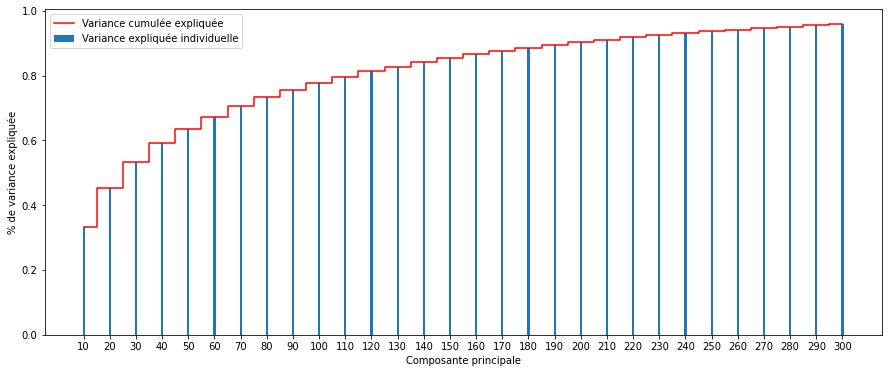

Avec 80 composantes, la variance expliquée est de 0.732297932504036
Temps d'execution 271.29 secondes


In [27]:
pca_variance(features_df, n_components = 300)


Application de la PCA avec 80 composantes

In [28]:
def pca_transform(df, n_components = 80):
  start_time = time.time()
  # Les données images sont converties au format vecteur dense
  ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
  df = df.withColumn('features', ud_f('features'))

  scaler = StandardScaler(inputCol = "features", outputCol = "scaled_features")
  scalerModel = scaler.fit(df)
  scaledData = scalerModel.transform(df)

  pca = PCA(k=n_components, inputCol='scaled_features', outputCol='pca_features')
  model = pca.fit(scaledData)
  df = model.transform(scaledData)

  print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
  return df

In [29]:
print("-----PCA on the features-----")
features_df = pca_transform(features_df, n_components = 80)

features_df.show(5)

-----PCA on the features-----
Temps d'execution 219.04 secondes
+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|     scaled_features|        pca_features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|file:/content/dri...|    Watermelon|[0.0,0.2798391580...|[0.0,0.4249758867...|[-10.432944118261...|
|file:/content/dri...|Pineapple Mini|[0.0,3.9853515625...|[0.0,6.0523277950...|[-17.151718356764...|
|file:/content/dri...|        Walnut|[0.05826935544610...|[0.10639772882780...|[-13.135079516906...|
|file:/content/dri...|         Guava|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-6.4850905930348...|
|file:/content/dri...|    Pepper Red|[0.41232338547706...|[0.75288754134121...|[-4.8965343044690...|
+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 5 rows



# Vérification de l'évolution des features

In [30]:
print("------Evolution du nombre de features------")
print("Nombre de charactère binaire de l'image :",len(images.select("content").collect()[1][0]))
print("Nombre de features après l'extraction par le modèle :",len(features_df.select("features").collect()[1][0]))
print("Nombre de features après la PCA :",len(features_df.select("pca_features").collect()[1][0]))
print("")

------Evolution du nombre de features------
Nombre de charactère binaire de l'image : 7229
Nombre de features après l'extraction par le modèle : 1280
Nombre de features après la PCA : 80



# Enregistrement des résultats

Les résultats seront enregistrés sur le S3 d'AWS dans le dossier Results en format parquet(qui permet de stocker de gros volumes)

In [ ]:
def save_results(df, path):
  start_time = time.time()
  df.write.mode("overwrite").parquet(path)
  print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))

In [31]:
# Pour ne pas stocker de données inutiles, nous ne gardons que les features après PCA
df_final = features_df.select(col("path"), col("label"),col("pca_features"))
df_final.show(5)
print("-----Saving the results-----")
save_results(df_final,PATH_Results)

-----Saving the results-----


NameError: ignored

# Exécution des fonctions

In [30]:
df_final.show(5)

+--------------------+--------------+--------------------+
|                path|         label|        pca_features|
+--------------------+--------------+--------------------+
|file:/content/dri...|    Watermelon|[-10.432944118261...|
|file:/content/dri...|Pineapple Mini|[-17.151718356764...|
|file:/content/dri...|        Walnut|[-13.135079516906...|
|file:/content/dri...|         Guava|[-6.4850905930348...|
|file:/content/dri...|    Pepper Red|[-4.8965343044690...|
+--------------------+--------------+--------------------+
only showing top 5 rows



# Lecture du fichier sauvegardé

In [23]:
df_results = pd.read_parquet(PATH_Results, engine="pyarrow")

In [24]:
df_results

,path,label,pca_features
0,file:/content/drive/MyDrive/Colab Notebooks/im...,Watermelon,"{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/content/drive/MyDrive/Colab Notebooks/im...,Pineapple Mini,"{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/content/drive/MyDrive/Colab Notebooks/im...,Walnut,"{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/content/drive/MyDrive/Colab Notebooks/im...,Guava,"{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/content/drive/MyDrive/Colab Notebooks/im...,Pepper Red,"{'type': 1, 'size': None, 'indices': None, 'va..."
...,...,...,...
585,file:/content/drive/MyDrive/Colab Notebooks/im...,Pear Williams,"{'type': 1, 'size': None, 'indices': None, 'va..."
586,file:/content/drive/MyDrive/Colab Notebooks/im...,Potato Sweet,"{'type': 1, 'size': None, 'indices': None, 'va..."
587,file:/content/drive/MyDrive/Colab Notebooks/im...,Cucumber Ripe 2,"{'type': 1, 'size': None, 'indices': None, 'va..."
588,file:/content/drive/MyDrive/Colab Notebooks/im...,Grape White 2,"{'type': 1, 'size': None, 'indices': None, 'va..."


In [29]:
df_results.iloc[0][2]["values"]

array([-1.04329441e+01,  1.85311356e+00, -7.68919495e+00,  7.62673739e-01,
       -6.06856864e+00, -8.17541805e+00,  4.27337079e+00, -3.07433808e+00,
       -5.49865153e+00,  1.53153429e+00, -4.21344628e+00, -9.04557439e+00,
        3.68987474e+00, -2.31211226e+00,  8.64211624e-01, -2.20380478e+00,
        2.05336586e+00,  1.77517414e+00, -1.57342539e+00, -3.64769599e+00,
        1.11392169e+01,  6.75088713e+00,  7.42340602e+00,  1.94397869e+00,
       -5.97110530e-01, -1.21806725e+00, -2.76867642e+00,  2.95629464e+00,
       -6.70744052e-01,  2.25436313e+00,  2.00120584e+00,  1.11266495e+01,
       -2.42628919e+00, -9.43804215e-01,  9.70009523e-01, -1.46153729e+00,
        1.62366846e+00, -2.73216078e+00,  2.31880812e+00, -4.63886812e+00,
        4.62653796e-01,  3.38368343e+00, -4.62621565e-01,  6.19976285e+00,
       -5.82441700e+00, -4.93796160e-01, -2.06850690e+00, -7.51024825e-01,
        1.96059590e+00, -1.97641776e+00, -3.03587504e+00, -3.61557061e+00,
        4.50159871e+00, -